In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading and Mapping

In [29]:
#Loading the Dataframe
Dataset = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset.shape[0],Dataset.shape[0]/5 , random_state=22)
Dataset_short = pd.DataFrame(Dataset.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

# Checking after shortening
print("Reduced Dataset Shape: ", Dataset_short.shape)

Reduced Dataset Shape:  (31560, 36)


In [30]:
# mapping and then sampling
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
temp = Attack_type.map(mapping_dict)
Attack_type_short = pd.DataFrame(temp.loc[indices.tolist()])

print("Before mapping", Attack_type.value_counts(normalize=True))
print("After mapping", Attack_type_short.value_counts(normalize=True))

Before mapping Attack_type
Normal                   0.153999
DDoS_UDP                 0.091876
DDoS_ICMP                0.089290
Ransomware               0.069233
DDoS_HTTP                0.066926
SQL_injection            0.065342
Uploading                0.065076
DDoS_TCP                 0.064937
Backdoor                 0.064607
Vulnerability_scanner    0.063853
Port_Scanning            0.063821
XSS                      0.063701
Password                 0.063302
MITM                     0.007693
Fingerprinting           0.006343
Name: proportion, dtype: float64
After mapping Attack_type
1              0.312579
5              0.197782
4              0.196198
6              0.153200
2              0.133080
3              0.007161
Name: proportion, dtype: float64


In [31]:
# Oversampling
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_short, Attack_type_short)
print(Attack_type_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Attack_type
1              0.312579
5              0.197782
4              0.196198
6              0.153200
2              0.133080
3              0.007161
Name: proportion, dtype: float64
Attack_type
1              0.218885
2              0.214590
5              0.190564
6              0.172318
3              0.108700
4              0.094943
Name: proportion, dtype: float64


In [32]:
#Train-Test split
X = Dataset_res.to_numpy() 
Y = Target_res.to_numpy(dtype='int')
print("X Shape: ", X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=22)
print ("Train Dataset Shape: ", X_train.shape, Y_train.shape)
print ("Test Dataset Shape: ", X_test.shape, Y_test.shape)

X Shape:  (30966, 36)
Train Dataset Shape:  (6193, 36) (6193, 1)
Test Dataset Shape:  (24773, 36) (24773, 1)


## Mapping Reference
1 = DDoS attacks<br>
2 = Scanning attacks<br>
3 = MITM attacks<br>
4 = Injection attacks<br> 
5 = Malware attacks<br>
6 = Normal<br>

## Linear SVC

### Determining Hyperparameter

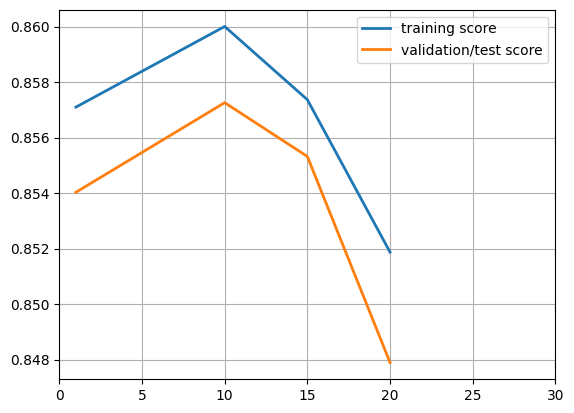

In [9]:
from sklearn.model_selection import validation_curve
from sklearn.svm import LinearSVC
# Optimum C parameter
C_param = [1, 10, 15, 20]
clf = LinearSVC()
train_score, test_score = validation_curve(clf, X_train, Y_train, param_name= 'C', param_range= C_param, cv=4)

fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 30))
plt.legend()
plt.show()

* There is no significance improvement on increasing the Parameter 'C'. Hence let the Parameter be default value which is 1.

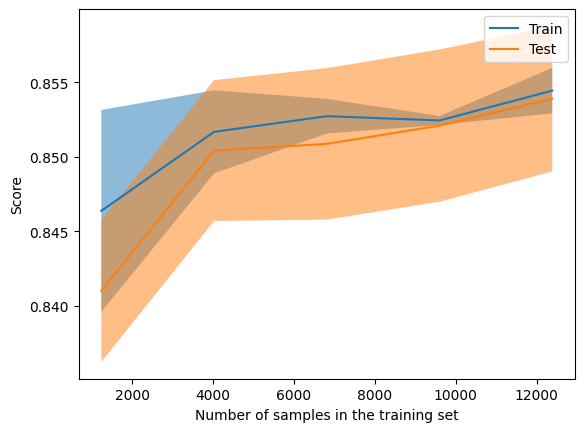

In [13]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=22)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, Y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

* No significant Improvement on increasing the number of samples aftter 4000.

### The Modal

In [15]:
from sklearn.svm import LinearSVC # one vs Rest/ one vs all
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=4000, random_state=22) 
lin_svc = LinearSVC()
mult_clf = lin_svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

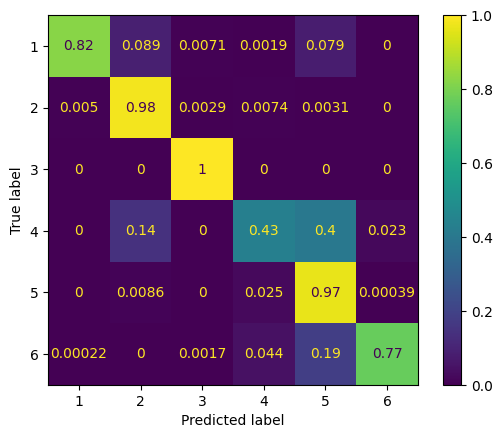

Average Accuracy: 0.8575984573166209
   Precision    Recall  F1-Score
1   0.993906  0.823322  0.900607
2   0.859786  0.981621  0.916673
3   0.977696  1.000000  0.988722
4   0.738482  0.431854  0.545000
5   0.677181  0.966290  0.796307
6   0.983023  0.766493  0.861358


In [18]:
from sklearn import metrics
# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

### The Modal after PCA

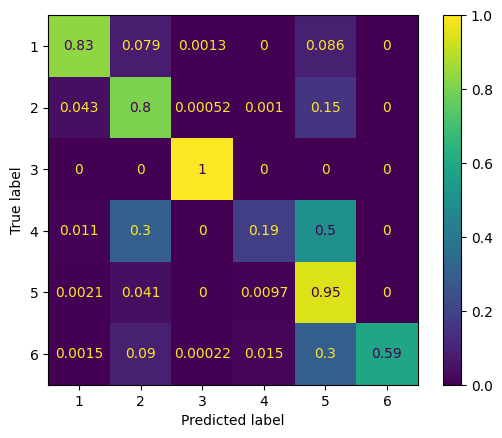

Average Accuracy: 0.7652599569828673
   Precision    Recall  F1-Score
1   0.943799  0.833586  0.885275
2   0.716626  0.804019  0.757811
3   0.995931  1.000000  0.997961
4   0.788851  0.185024  0.299743
5   0.545740  0.947389  0.692543
6   1.000000  0.593533  0.744927


In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_PCA = pca.fit_transform(X)
Y = Target_res.to_numpy(dtype='int')

# train test splitting 
X_train, X_test, Y_train, Y_test = train_test_split(X_PCA, Y, train_size=4000, random_state=22) 
lin_svc = LinearSVC()
mult_clf = lin_svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

### The Modal after RF Feature Selection

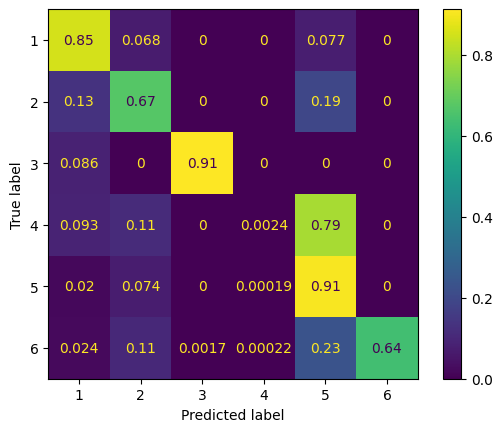

Average Accuracy: 0.7139731513758065
   Precision    Recall  F1-Score
1   0.773967  0.854451  0.812220
2   0.715096  0.671247  0.692478
3   0.997027  0.913517  0.953447
4   0.750000  0.002377  0.004739
5   0.499141  0.905495  0.643540
6   1.000000  0.636068  0.777557


In [22]:
import pickle as pkl
Features = pkl.load(open("Features_RFFS.pkl", "rb"))
X = Dataset_res[Features].to_numpy()
Y = Target_res.to_numpy(dtype='int')

# train test splitting 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=4000, random_state=22) 
lin_svc = LinearSVC()
mult_clf = lin_svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

## SVC

### Determining Hyperparameter

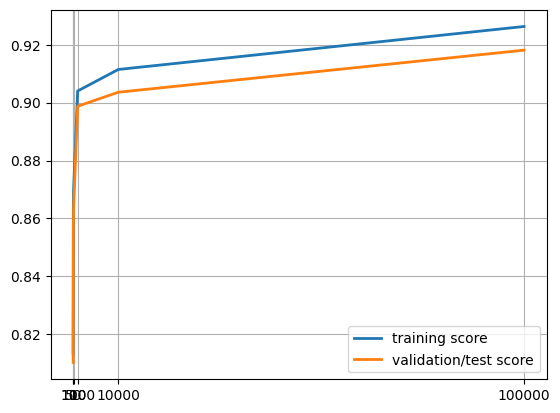

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

C_param = [1, 50, 100, 1000, 10000, 1e5]
svc = SVC(kernel='rbf', decision_function_shape= 'ovo')
train_score, test_score = validation_curve(svc, X_train, Y_train, param_name= 'C', param_range= C_param, cv=4)

fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set_xticks(C_param)
plt.legend()
plt.show()

* The parameter C of value 1e4 is enough for the modal to give optimum result

### The Modal 

In [44]:
from sklearn.svm import SVC # one vs one
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 4000, random_state=22) 
svc = SVC(kernel ='rbf', C= 1e4, decision_function_shape= 'ovo')
mult_clf = svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

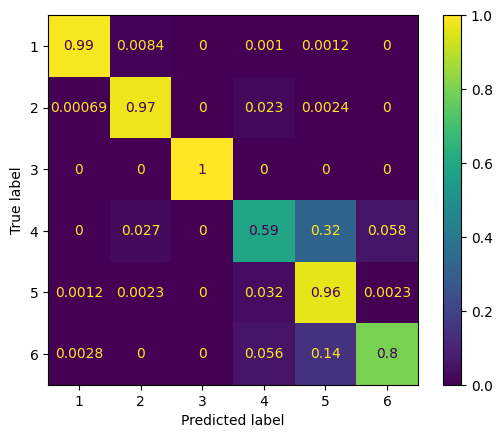

Average Accuracy: 0.9123711340206185
   Precision    Recall  F1-Score
1   0.996104  0.989399  0.992740
2   0.977594  0.974236  0.975912
3   1.000000  1.000000  1.000000
4   0.728335  0.592710  0.653561
5   0.767760  0.962393  0.854129
6   0.958822  0.798394  0.871285


In [45]:
from sklearn import metrics
# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

### The Modal after PCA

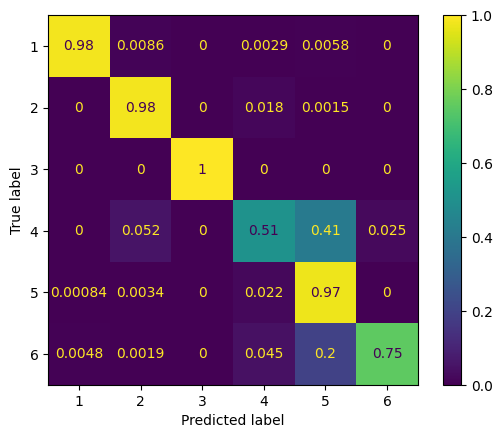

Average Accuracy: 0.898611559573781
   Precision    Recall  F1-Score
1   0.995627  0.982734  0.989138
2   0.963130  0.980843  0.971906
3   1.000000  1.000000  1.000000
4   0.753731  0.510101  0.608434
5   0.716841  0.974015  0.825871
6   0.981013  0.750969  0.850714


In [46]:
from sklearn.svm import SVC # one vs one

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_PCA = pca.fit_transform(X)

# splitting train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_PCA, Y, test_size=0.2, random_state=22) 

mult_clf = svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

### The Modal after RF Feature Selection

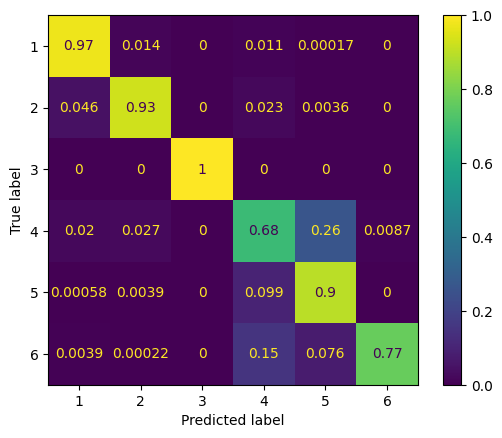

Average Accuracy: 0.8897871393606764
   Precision    Recall  F1-Score
1   0.945007  0.974424  0.959490
2   0.968632  0.928203  0.947987
3   1.000000  1.000000  1.000000
4   0.551060  0.679873  0.608726
5   0.815701  0.896921  0.854385
6   0.993829  0.768880  0.867001


In [47]:
import pickle as pkl
Features = pkl.load(open("Features_RFFS.pkl", "rb"))
X = Dataset_res[Features].to_numpy()
Y = Target_res.to_numpy(dtype='int')

# train test splitting 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=4000, random_state=22) 

#training and predicting the model
mult_clf = svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)


# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= mult_clf.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= mult_clf.classes_)
print(df_metric)

## Conclusion

The Multiclass classification is performed by LinearSVC and SVC model. The **Linear-SVC uses OnevsRest** method to classify the samples. Whereas the **SVC uses OnevsOne**. The Hyperparameter for each Algorithm is evaluated and trained with sampled Datapoints (SMOTEENN). The results are compared from with and wthout PCA application.<br>

The Results shows that the SVC have a better Result than Linear SVC. But Both of the method perform least by the classification of Injection attacks.<br>
To note is that the 41% of the misclassified Injection Attacks (class = 4) is classified as Malware Attacks (class = 5) and almost negligible percentage as normal sample (class = 6). <br>
The dimension Reduction by SVC worked considerably well. Halved its Training time and produced almost the same result.
